# 401 CNN


In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded

In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


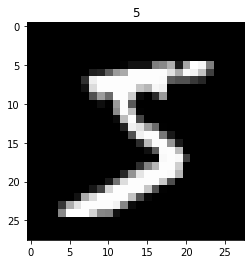

In [5]:
# plot one example
print(train_data.data.size())                 # (60000, 28, 28)
print(train_data.targets.size())               # (60000)
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [6]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.targets[:2000]

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization x是CNN最后一层训练的参数结果

In [9]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [10]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [31]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

In [26]:
import optuna

DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

In [48]:
def define_model(trial):
    # We optimize the number of layers, hidden untis and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        kernel_size = trial.suggest_int("kernal_size{}".format(i), 1, 3)
        layers.append(nn.Conv2d(in_features, out_features,kernel_size))
        #layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU(inplace = True))
        p = trial.suggest_uniform("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def get_mnist():
    # Load MNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader

In [49]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the MNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    model.train()
    for epoch in range(EPOCHS):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(-1, 28 * 28).to(DEVICE), target.to(DEVICE)

            # Zeroing out gradient buffers.
            optimizer.zero_grad()
            # Performing a forward pass.
            output = model(data)
            # Computing negative Log Likelihood loss.
            loss = F.nll_loss(output, target)
            # Performing a backward pass.
            loss.backward()
            # Updating the weights.
            optimizer.step()

    # Validation of the model.
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Limiting validation data.
            if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                break
            data, target = data.view(-1, 28 * 28).to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability.
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / N_VALID_EXAMPLES
    return accuracy

In [50]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-05-31 21:46:45,326] A new study created in memory with name: no-name-3eb1240d-4458-4467-8d77-ca4ef9332aa8
[W 2021-05-31 21:46:45,371] Trial 0 failed because of the following error: RuntimeError('Expected 4-dimensional input for 4-dimensional weight [63, 784, 2, 2], but got 2-dimensional input of size [128, 784] instead')
Traceback (most recent call last):
  File "C:\Users\xuhan\anaconda3\lib\site-packages\optuna\_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-49-f8146b0d720a>", line 27, in objective
    output = model(data)
  File "C:\Users\xuhan\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "C:\Users\xuhan\anaconda3\lib\site-packages\torch\nn\modules\container.py", line 119, in forward
    input = module(input)
  File "C:\Users\xuhan\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 889, in _call_impl
    result = self.forward(*input

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [63, 784, 2, 2], but got 2-dimensional input of size [128, 784] instead

In [11]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing

In [12]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing

Epoch:  0 | train loss: 2.3125 | test accuracy: 0.18


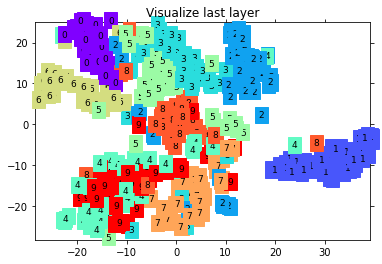

Epoch:  0 | train loss: 0.3738 | test accuracy: 0.90


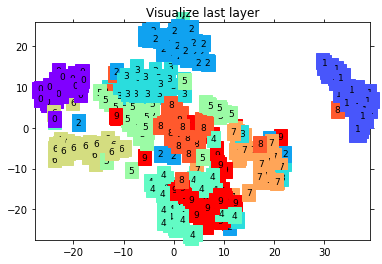

Epoch:  0 | train loss: 0.2342 | test accuracy: 0.93


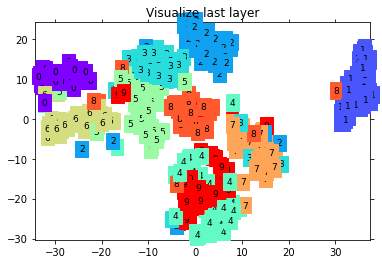

Epoch:  0 | train loss: 0.0554 | test accuracy: 0.95


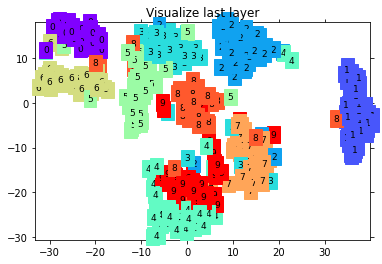

Epoch:  0 | train loss: 0.0681 | test accuracy: 0.96


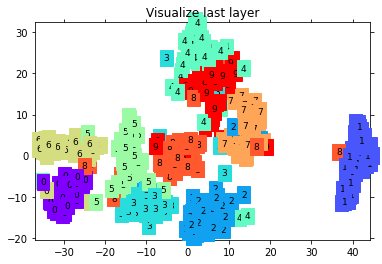

Epoch:  0 | train loss: 0.0830 | test accuracy: 0.97


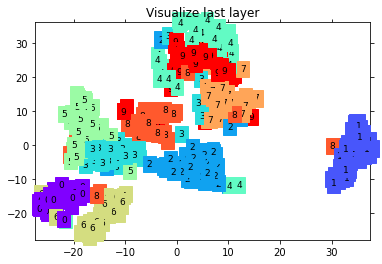

Epoch:  0 | train loss: 0.0392 | test accuracy: 0.96


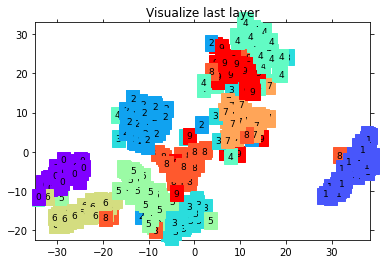

Epoch:  0 | train loss: 0.0197 | test accuracy: 0.96


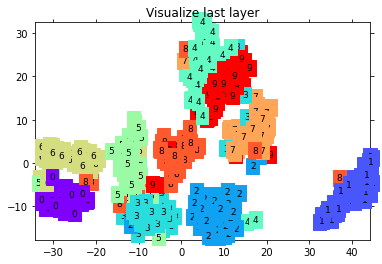

Epoch:  0 | train loss: 0.2306 | test accuracy: 0.96


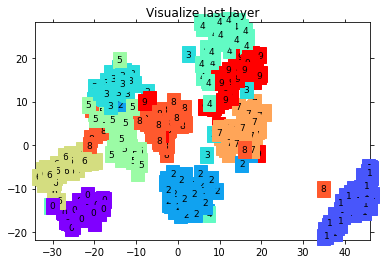

Epoch:  0 | train loss: 0.0443 | test accuracy: 0.97


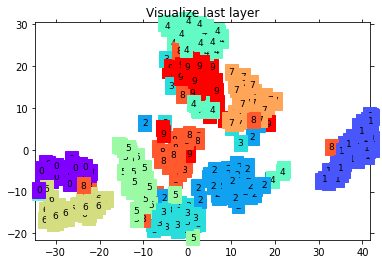

Epoch:  0 | train loss: 0.0121 | test accuracy: 0.97


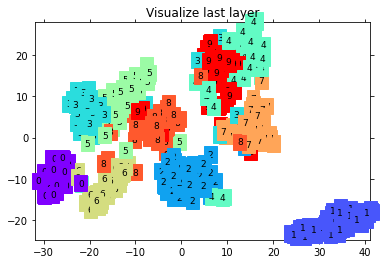

Epoch:  0 | train loss: 0.0258 | test accuracy: 0.98


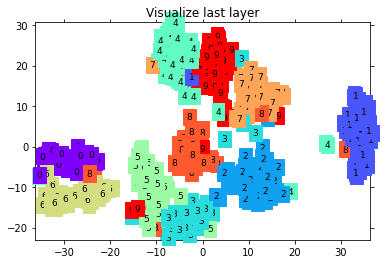

In [13]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        loss = loss.item()
        if step % 100 == 0:#100的倍数batch（共12个）
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()#yhat = torch.max(sigma,1)[1]预测值
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30 #float, 默认为30，数据集越大，需要参数值越大，建议值位5-50
                            , n_components=2 #int, 默认为2，嵌入空间的维度（嵌入空间的意思就是结果空间）
                            , init='pca' #string or numpy array, default:”random”, 可以是’random’, ‘pca’或者一个numpy数组(shape=(n_samples, n_components)。
                            , n_iter=5000 #int, default:1000, 最大迭代次数
                           )
                plot_only = 500
                tobe_tsne = last_layer.data.numpy()[:plot_only, :]#[500,32*7*7]
                #tobe_tsne = normalize(tobe_tsne)
                low_dim_embs = tsne.fit_transform(tobe_tsne)#[2000,32*7*7],一个batch里最后一层的特征图
                
                #print(tobe_tsne[0].shape)#[2000,32*7*7]
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
                #break
plt.ioff()

In [15]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
